In [39]:
import librosa, librosa.display
import numpy as np
from pydub import AudioSegment
import my_utils
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

n_fft = 1024
hop_length = 8
sr = 16000

# cate bucati PF iau in considerare pentru AF -> cu overlapping => 15 frame-uri 
# ultimul frame din AF fiind PF-ul curent
nb_of_PFs_per_AF = 4
nb_of_frames_in_AF = 4

In [40]:
def get_STFT_AF_frames(AF_array, PF_size):
    frames = []
    half = (int)(PF_size/2)
    frames_added = 0
    
    i = AF_array.shape[0]-1
    
    # use AF as 4 times bigger than PF's size -> PF = 10 ms => AF = 40 ms
    
    #---------------------------------------------------------------------------
    # 1. add PF[i]
    frame = librosa.stft(librosa.to_mono(AF_array[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    
    tensor = []
    tensor.append(frame)        
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 2. add PF[i-1, i] -> overlap
    overlap_frame = AF_array[i-1][half:]
    overlap_frame = np.concatenate((overlap_frame, AF_array[i][:half]))
    
    frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)

    tensor = []
    tensor.append(frame)
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 3. add PF[i - 1]
    frame = librosa.stft(librosa.to_mono(AF_array[i - 1]), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    
    tensor = []
    tensor.append(frame)        
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 4. add PF[i-1, i] -> overlap
    overlap_frame = AF_array[i-1][half:]
    overlap_frame = np.concatenate((overlap_frame, AF_array[i][:half]))
    
    frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)

    tensor = []
    tensor.append(frame)
    frames.append(tensor)
                      
#     for i in range (0, AF_array.shape[0]):

#         # 1. add current frame from AF
#         frame = librosa.stft(librosa.to_mono(AF_array[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
#         frame = np.abs(frame)
        
#         tensor = []
#         tensor.append(frame)        
#         frames.append(tensor)
        
#         # 2. add overlapped frame if the current frame is not the last one
#         if i < AF_array.shape[0]-1:
#             overlap_frame = AF_array[i][half:]
#             overlap_frame = np.concatenate((overlap_frame, AF_array[i+1][:half]))
            
#             frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
#             frame = np.abs(frame)

#             tensor = []
#             tensor.append(frame)
#             frames.append(tensor)
        
    
    return np.asarray(frames)

In [51]:
def get_train_set_for_mix(mix, voice_1, voice_2, samples_per_frame):
    inputs = []
    targets = []
    
    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_1_frames = np.array([voice_1[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_2_frames = np.array([voice_2[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    
    for index in range(mix_frames.shape[0]):
        
        if index < 2:
            continue
        
        # 1. create train set input for AF with current PF and previous frames
        AF_frames = np.array([mix_frames[i] for i in range(index - 2, index)])      
        AF_STFT_frames = get_STFT_AF_frames(AF_array=AF_frames, PF_size= samples_per_frame)
        inputs.append(AF_STFT_frames)
        
        # 2. create train set target for that AF, containing the mask for the current PF
        stft_voice_1 = librosa.stft(librosa.to_mono(voice_1_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        stft_voice_2 = librosa.stft(librosa.to_mono(voice_2_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        mask = my_utils.compute_mask(stft_voice_1, stft_voice_2)
        
        targets.append(mask)
    
    # train set for only one audio
    train_set_input = torch.from_numpy(np.array(inputs))
    print(train_set_input.shape)
    
    # target contains the calculated masks for each PF from mix
    train_set_target = torch.from_numpy(np.array(targets))

    print(train_set_input.shape)
#     assert(train_set_input.shape == (996, 4, 1, 513, 11))
#     assert(train_set_target.shape == (996, 513, 11))
    train_set = dict(zip(train_set_input, train_set_target))
    return train_set, train_set_target
    

In [42]:
class Network(nn.Module):
    height = 0
    width = 0
    
    # default values for height and width are given for a processing frame of 5 ms
    def __init__(self, height = 513, width = 21):
        super(Network, self).__init__()
        self.height = height
        self.width = width
        
        # layer 1
        self.fc1 = nn.Linear(1 * height * width, 250)
        self.fc1_batch = nn.BatchNorm1d(250)
        
        # layer 2
        self.fc2 = nn.Linear(250, 250)
        self.fc2_batch = nn.BatchNorm1d(250)
        
        # layer 3
        self.fc3 = nn.Linear(250, height * width)
        self.fc3_batch = nn.BatchNorm1d(height * width)

    def forward(self, x):
        
        # layer 1
        # firstly, transform the matrix into an array for the FC
        x = x.view(-1, self.height * self.width)        
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc1_batch(x)
#         print("1 shapes: ", x.shape)
        
        # layer 2
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.fc2_batch(x)
#         print("2 shapes: ", x.shape)
        
        # layer 3
        x = self.fc3(x)
        x = torch.sigmoid(x)
        x = self.fc3_batch(x)
        
#         x = x.view(nb_of_PFs_per_AF * 2 - 1, self.height, self.width) 
        x = x.view(nb_of_frames_in_AF, self.height, self.width) 
#         print("3 shapes: ", x.shape)
        
        return x

In [43]:
# create network
# no params => height = 513, width = 11 -> for a processing frame of 5 ms
network = Network()

# if cuda is available, send network's params to gpu
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("network sent to CUDA")
    network.cuda()
    
# set optimizer -> article : Adam, lr = 0.001, b1 = 0.9, b2 = 0.999
optimizer = optim.Adam(network.parameters(), lr = 0.001, betas = (0.9, 0.999))
loss_function = nn.MSELoss()

network sent to CUDA


In [44]:
# init arrays for train/test errors
# train_losses = []
# train_counter = []

# test_losses = []
# test_counter = [i*len(train_set) for i in range(n_epochs)]

In [59]:
male_filename = 'recordings/voice2/arctic_a0002.wav'
female_filename = 'recordings/voice1/arctic_a0001.wav'

male, sr = librosa.load(male_filename, sr=16000) 
female, sr = librosa.load(female_filename, sr=16000) 

# pad smaller array with zeros, so both audio files have the same length
female, male = my_utils.make_wav_files_same_size(female, male)

# load the mixed audio 
mix = female + male

male = np.array(male)
female = np.array(female)
mix = np.array(mix)

frame_length_ms = 10
mix_length_ms = len(mix) / sr * 1000
samples_per_frame = (int)(len(mix) * frame_length_ms / mix_length_ms)

print("mix total length: ",len(mix))
print("mix total length (ms) : ", mix_length_ms)
print("nb of samples for", frame_length_ms,"ms frame =", samples_per_frame, "samples/array")
print("---------------------------------------------------------")


train_set, targets = get_train_set_for_mix(mix, female, male, samples_per_frame)

# make test set the same as train set so I can test the overfitting
test_set, targets = get_train_set_for_mix(mix, female, male, samples_per_frame) 
print("AF entries in train_set: ",len(train_set))

# print(targets.shape)
# split_audios_epoch("TEST-mask", targets)

mix total length:  80000
mix total length (ms) :  5000.0
nb of samples for 10 ms frame = 160 samples/array
---------------------------------------------------------
torch.Size([498, 4, 1, 513, 21])
torch.Size([498, 4, 1, 513, 21])
torch.Size([498, 4, 1, 513, 21])
torch.Size([498, 4, 1, 513, 21])
AF entries in train_set:  498


In [64]:
def train_network(nr_epochs, train_set, test_set):

    mask = []
    mask_test = []

    last_valid_loss = 0
    nb_of_epochs_for_valid_loss = 0

    # plot train/valid loss contains losses on each epoch, so we can see after each epoch what happens with the error
    plot_train_loss = []
    plot_valid_loss = []
    
    
    target_height = 0
    target_width = 0

    for epoch in range(1, nr_epochs+1):
        mask = []
        mask_test = []

        train_loss, valid_loss = [], []
        loss = 0

        print("--------------------------------------Epoch", str(epoch) ,"------------------------------")
        ## training part 
        network.train()
        for index, (input, target) in enumerate(train_set.items()):

            # target is transformed from a matrix to an array, so the error can be calculated easier
            # since the network returns an array
            if index == 0:
                target_height = target.shape[0]
                target_width = target.shape[1]
            
#             target_view = target.view(-1, target.shape[0] * target.shape[1])

            # if cuda is available, send (input, target) to gpu
            if torch.cuda.is_available():
                input, target = input.cuda(), target.cuda()

            optimizer.zero_grad()

            # 1. forward propagation
            output = network(input)


            # 2. loss calculation
            loss = loss_function(target, output[len(output)-1])  


            # 3. backward propagation
            loss.backward() 


            # 4. weight optimization
            optimizer.step()


            # 5. save the loss for this PF
            train_loss.append(loss.item())


            # 6. save the mask for the current PF, meaning the last entry in the output[AF]
            current_mask = output[len(output)-1]#.view(target_height, target_width)
            mask.append(current_mask)

        # add the mean loss for this training epoch for ploting
        plot_train_loss.append(np.mean(train_loss))

        #-----------------------------------------------------------------------
        ## evaluation part 
        
        if epoch % 100 == 0:
#             network.eval()
            with torch.no_grad():
                for index, (input, target) in enumerate(test_set.items()):

                    # if cuda is available, send (input, target) to gpu
        #             target_view = target.view(-1, target.shape[0] * target.shape[1])
                    if torch.cuda.is_available():
                        input, target = input.cuda(), target.cuda()

                    # 1. forward propagation
                    output = network.forward(input)

                    # 2. loss calculation
                    loss = loss_function(target, output[len(output)-1]).detach().item()

                    # 6. save the mask for the current PF, meaning the last entry in the output
                    current_mask = output[len(output)-1]#.view(target_height, target_width)
                    mask_test.append(current_mask)

                    if loss != last_valid_loss:
                        last_valid_loss = loss
                    else:
                        nb_of_epochs_for_valid_loss += 1

                    valid_loss.append(loss)

                # add the mean loss for this training epoch for ploting
                plot_valid_loss.append(np.mean(valid_loss))

                # check if we have the same loss for validation set
                if last_valid_loss == (np.mean(valid_loss)):
                    nb_of_epochs_for_valid_loss += 1
                    print("nb_of_epochs_for_valid_loss increased with one, loss:", last_valid_loss)
                else:
                    last_valid_loss = np.mean(valid_loss)

                
        print ("\nTraining Loss: ", np.mean(train_loss), "\nValid Loss: ", np.mean(valid_loss))
        if(nb_of_epochs_for_valid_loss == 20):
            print("Early stopping training, same loss for 20 epochs!")
            break

    torch.save(network, './model.pth')
#     plt.plot(plot_train_loss)
#     plt.title('train losses')
#     plt.show()

#     plt.plot(plot_valid_loss)
#     plt.title('valid losses')
#     plt.show()
    
    plt.plot(plot_train_loss, label='Training loss')
    plt.plot(plot_valid_loss, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
    return mask, mask_test


In [63]:
# RECONSTRUIRE SUNET PE FRAME-URI, FOLOSIND TARGETURILE GENERATE PT SETUL DE ANTRENARE
def split_audios_epoch(name, mask):
    frame_pos = (int)(nb_of_frames_in_AF/2)
#     n_mask = mask.detach().numpy()


    mask_stack = torch.stack(mask)
#     print(mask_stack.shape)

    cpu_mask = mask_stack.cpu()
#     print(cpu_mask.shape)

    n_mask = cpu_mask.detach().numpy()
#     print(n_mask.shape)

    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    sound1 = np.empty([0,])
    sound2 = np.empty([0,])


    for i in range (0, len(mix_frames)):
        stft_mix = librosa.stft(librosa.to_mono(mix_frames[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
        

        # reteaua nu a invatat mastile pentru primele frame_pos bucati [PF] din mix
        # deci las matricea STFT asa cum e in mix
        if i < frame_pos :
            y_frame_1_stft_with_mask = stft_mix
            y_frame_2_stft_with_mask = stft_mix

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))
            
        else:
            # n_mask[i-7] pentru ca reteaua invata pt AF-uri facute pe cate 8 PF-uri -> 15 items pt AF
            # abia de cand ajunge la primul AF care s a putut compune, folosesc masca invata de retea
            
            y_frame_1_stft_with_mask = np.multiply(n_mask[i-frame_pos], stft_mix)
            y_frame_2_stft_with_mask = np.multiply((1 -  n_mask[i-frame_pos]), stft_mix)

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))


    librosa.output.write_wav("recordings/DNN-voice1-"+ str(name) + ".wav", sound1, sr = 16000)
    librosa.output.write_wav("recordings/DNN-voice2-"+ str(name) + ".wav", sound2, sr = 16000)

In [66]:
def eval(network, test_set):

#     network.eval()
                
    valid_loss, valid_mask = [], []
    target_height, target_width = 0, 0

    for index, (input, target) in enumerate(test_set.items()):

            # if cuda is available, send (input, target) to gpu
#             target_view = target.view(-1, target.shape[0] * target.shape[1])
        if torch.cuda.is_available():
            input, target = input.cuda(), target.cuda()

        # 1. forward propagation
        output = network.forward(input)

        # 2. loss calculation
        loss = loss_function(target, output[len(output)-1]).detach().item()

        # 6. save the mask for the current PF, meaning the last entry in the output
        current_mask = output[len(output)-1]#.view(target_height, target_width)
        valid_mask.append(current_mask)

        valid_loss.append(loss)
#         print("Loss", loss)



    print("Validation set loss:", np.mean(valid_loss))

    plt.plot(valid_loss)
    plt.title('valid losses')
    plt.show()  
    
    return valid_mask


--------------------------------------Epoch 1 ------------------------------


C:\Users\Lenovo\Anaconda3\envs\machine-learning\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Lenovo\Anaconda3\envs\machine-learning\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Training Loss:  0.36539572001580733 
Valid Loss:  nan
--------------------------------------Epoch 2 ------------------------------

Training Loss:  0.21507250053067523 
Valid Loss:  nan
--------------------------------------Epoch 3 ------------------------------

Training Loss:  0.16559216930684315 
Valid Loss:  nan
--------------------------------------Epoch 4 ------------------------------

Training Loss:  0.1500386393902053 
Valid Loss:  nan
--------------------------------------Epoch 5 ------------------------------

Training Loss:  0.14061795531895505 
Valid Loss:  nan
--------------------------------------Epoch 6 ------------------------------

Training Loss:  0.14028936908786077 
Valid Loss:  nan
--------------------------------------Epoch 7 ------------------------------

Training Loss:  0.13862546241606574 
Valid Loss:  nan
--------------------------------------Epoch 8 ------------------------------

Training Loss:  0.13429312227690315 
Valid Loss:  nan
----------------------


Training Loss:  0.09073808276838806 
Valid Loss:  nan
--------------------------------------Epoch 64 ------------------------------

Training Loss:  0.09912023430289962 
Valid Loss:  nan
--------------------------------------Epoch 65 ------------------------------

Training Loss:  0.09982654434651227 
Valid Loss:  nan
--------------------------------------Epoch 66 ------------------------------

Training Loss:  0.09288020264198368 
Valid Loss:  nan
--------------------------------------Epoch 67 ------------------------------

Training Loss:  0.09116957373529051 
Valid Loss:  nan
--------------------------------------Epoch 68 ------------------------------

Training Loss:  0.08841049746609289 
Valid Loss:  nan
--------------------------------------Epoch 69 ------------------------------

Training Loss:  0.08761457469707998 
Valid Loss:  nan
--------------------------------------Epoch 70 ------------------------------

Training Loss:  0.08804241290276713 
Valid Loss:  nan
--------------


Training Loss:  0.07366870045205608 
Valid Loss:  nan
--------------------------------------Epoch 126 ------------------------------

Training Loss:  0.07043719779577043 
Valid Loss:  nan
--------------------------------------Epoch 127 ------------------------------

Training Loss:  0.06968065720403652 
Valid Loss:  nan
--------------------------------------Epoch 128 ------------------------------

Training Loss:  0.06592690776222984 
Valid Loss:  nan
--------------------------------------Epoch 129 ------------------------------

Training Loss:  0.06627932462023853 
Valid Loss:  nan
--------------------------------------Epoch 130 ------------------------------

Training Loss:  0.06781287573238912 
Valid Loss:  nan
--------------------------------------Epoch 131 ------------------------------

Training Loss:  0.06932060464986896 
Valid Loss:  nan
--------------------------------------Epoch 132 ------------------------------

Training Loss:  0.07002549578628459 
Valid Loss:  nan
-------


Training Loss:  0.07140499168066942 
Valid Loss:  nan
--------------------------------------Epoch 188 ------------------------------

Training Loss:  0.06916803047379216 
Valid Loss:  nan
--------------------------------------Epoch 189 ------------------------------

Training Loss:  0.06978139157391675 
Valid Loss:  nan
--------------------------------------Epoch 190 ------------------------------

Training Loss:  0.06510879728955798 
Valid Loss:  nan
--------------------------------------Epoch 191 ------------------------------

Training Loss:  0.06433016111094435 
Valid Loss:  nan
--------------------------------------Epoch 192 ------------------------------

Training Loss:  0.061808839026209726 
Valid Loss:  nan
--------------------------------------Epoch 193 ------------------------------

Training Loss:  0.06019570242020987 
Valid Loss:  nan
--------------------------------------Epoch 194 ------------------------------

Training Loss:  0.06331391214470784 
Valid Loss:  nan
------


Training Loss:  0.05945669891909244 
Valid Loss:  nan
--------------------------------------Epoch 250 ------------------------------

Training Loss:  0.055674703476734616 
Valid Loss:  nan
--------------------------------------Epoch 251 ------------------------------

Training Loss:  0.052609042752324406 
Valid Loss:  nan
--------------------------------------Epoch 252 ------------------------------

Training Loss:  0.052512195150395756 
Valid Loss:  nan
--------------------------------------Epoch 253 ------------------------------

Training Loss:  0.052555678412194044 
Valid Loss:  nan
--------------------------------------Epoch 254 ------------------------------

Training Loss:  0.05408506151950378 
Valid Loss:  nan
--------------------------------------Epoch 255 ------------------------------

Training Loss:  0.05704600363223214 
Valid Loss:  nan
--------------------------------------Epoch 256 ------------------------------

Training Loss:  0.05664833718176223 
Valid Loss:  nan
---


Training Loss:  0.0506495823686759 
Valid Loss:  nan
--------------------------------------Epoch 311 ------------------------------

Training Loss:  0.049724713761902586 
Valid Loss:  nan
--------------------------------------Epoch 312 ------------------------------

Training Loss:  0.048828792009245885 
Valid Loss:  nan
--------------------------------------Epoch 313 ------------------------------

Training Loss:  0.05225077387633729 
Valid Loss:  nan
--------------------------------------Epoch 314 ------------------------------

Training Loss:  0.05059695000808968 
Valid Loss:  nan
--------------------------------------Epoch 315 ------------------------------

Training Loss:  0.046560696547338555 
Valid Loss:  nan
--------------------------------------Epoch 316 ------------------------------

Training Loss:  0.05376989686976822 
Valid Loss:  nan
--------------------------------------Epoch 317 ------------------------------

Training Loss:  0.05326976281064772 
Valid Loss:  nan
-----


Training Loss:  0.04536193935722162 
Valid Loss:  nan
--------------------------------------Epoch 373 ------------------------------

Training Loss:  0.04516731998815414 
Valid Loss:  nan
--------------------------------------Epoch 374 ------------------------------

Training Loss:  0.050796889110148936 
Valid Loss:  nan
--------------------------------------Epoch 375 ------------------------------

Training Loss:  0.05333191714062451 
Valid Loss:  nan
--------------------------------------Epoch 376 ------------------------------

Training Loss:  0.04950691804718 
Valid Loss:  nan
--------------------------------------Epoch 377 ------------------------------

Training Loss:  0.046017467147670375 
Valid Loss:  nan
--------------------------------------Epoch 378 ------------------------------

Training Loss:  0.04644096138031181 
Valid Loss:  nan
--------------------------------------Epoch 379 ------------------------------

Training Loss:  0.04377303669726903 
Valid Loss:  nan
--------


Training Loss:  0.04301184707110334 
Valid Loss:  nan
--------------------------------------Epoch 434 ------------------------------

Training Loss:  0.04178503005879653 
Valid Loss:  nan
--------------------------------------Epoch 435 ------------------------------

Training Loss:  0.0433241531171054 
Valid Loss:  nan
--------------------------------------Epoch 436 ------------------------------

Training Loss:  0.04501135151261783 
Valid Loss:  nan
--------------------------------------Epoch 437 ------------------------------

Training Loss:  0.045068848857382986 
Valid Loss:  nan
--------------------------------------Epoch 438 ------------------------------

Training Loss:  0.04350742501823019 
Valid Loss:  nan
--------------------------------------Epoch 439 ------------------------------

Training Loss:  0.04375315372620556 
Valid Loss:  nan
--------------------------------------Epoch 440 ------------------------------

Training Loss:  0.043170049831810484 
Valid Loss:  nan
------


Training Loss:  0.04379511165858042 
Valid Loss:  nan
--------------------------------------Epoch 496 ------------------------------

Training Loss:  0.04419664232782397 
Valid Loss:  nan
--------------------------------------Epoch 497 ------------------------------

Training Loss:  0.04297534655774304 
Valid Loss:  nan
--------------------------------------Epoch 498 ------------------------------

Training Loss:  0.04452284089546149 
Valid Loss:  nan
--------------------------------------Epoch 499 ------------------------------

Training Loss:  0.046097366772888185 
Valid Loss:  nan
--------------------------------------Epoch 500 ------------------------------

Training Loss:  0.044952016807035096 
Valid Loss:  0.0512700126592739
--------------------------------------Epoch 501 ------------------------------

Training Loss:  0.04182038646468758 
Valid Loss:  nan
--------------------------------------Epoch 502 ------------------------------

Training Loss:  0.04128953695906595 
Valid L


Training Loss:  0.04920542618246434 
Valid Loss:  nan
--------------------------------------Epoch 557 ------------------------------

Training Loss:  0.04910479966546076 
Valid Loss:  nan
--------------------------------------Epoch 558 ------------------------------

Training Loss:  0.04255822990073437 
Valid Loss:  nan
--------------------------------------Epoch 559 ------------------------------

Training Loss:  0.04551861531886919 
Valid Loss:  nan
--------------------------------------Epoch 560 ------------------------------

Training Loss:  0.04950255345710206 
Valid Loss:  nan
--------------------------------------Epoch 561 ------------------------------

Training Loss:  0.04313397950268318 
Valid Loss:  nan
--------------------------------------Epoch 562 ------------------------------

Training Loss:  0.04565523465454138 
Valid Loss:  nan
--------------------------------------Epoch 563 ------------------------------

Training Loss:  0.04415621973370742 
Valid Loss:  nan
-------


Training Loss:  0.04163075132975287 
Valid Loss:  nan
--------------------------------------Epoch 618 ------------------------------

Training Loss:  0.03753590346540218 
Valid Loss:  nan
--------------------------------------Epoch 619 ------------------------------

Training Loss:  0.03798630552351408 
Valid Loss:  nan
--------------------------------------Epoch 620 ------------------------------

Training Loss:  0.03986709956799391 
Valid Loss:  nan
--------------------------------------Epoch 621 ------------------------------

Training Loss:  0.040647134120695136 
Valid Loss:  nan
--------------------------------------Epoch 622 ------------------------------

Training Loss:  0.04166218997621202 
Valid Loss:  nan
--------------------------------------Epoch 623 ------------------------------

Training Loss:  0.04107984770127795 
Valid Loss:  nan
--------------------------------------Epoch 624 ------------------------------

Training Loss:  0.042669878416667105 
Valid Loss:  nan
-----


Training Loss:  0.03922135411946272 
Valid Loss:  nan
--------------------------------------Epoch 680 ------------------------------

Training Loss:  0.039909205553637646 
Valid Loss:  nan
--------------------------------------Epoch 681 ------------------------------

Training Loss:  0.03934123740994649 
Valid Loss:  nan
--------------------------------------Epoch 682 ------------------------------

Training Loss:  0.036351339085362575 
Valid Loss:  nan
--------------------------------------Epoch 683 ------------------------------

Training Loss:  0.038223961847263975 
Valid Loss:  nan
--------------------------------------Epoch 684 ------------------------------

Training Loss:  0.04004292275079802 
Valid Loss:  nan
--------------------------------------Epoch 685 ------------------------------

Training Loss:  0.03798399848748492 
Valid Loss:  nan
--------------------------------------Epoch 686 ------------------------------

Training Loss:  0.03652781274089681 
Valid Loss:  nan
----


Training Loss:  0.03754990969058686 
Valid Loss:  nan
--------------------------------------Epoch 741 ------------------------------

Training Loss:  0.03843804833174917 
Valid Loss:  nan
--------------------------------------Epoch 742 ------------------------------

Training Loss:  0.03858994791228297 
Valid Loss:  nan
--------------------------------------Epoch 743 ------------------------------

Training Loss:  0.03849093725785043 
Valid Loss:  nan
--------------------------------------Epoch 744 ------------------------------

Training Loss:  0.03996584935752724 
Valid Loss:  nan
--------------------------------------Epoch 745 ------------------------------

Training Loss:  0.04276463478906013 
Valid Loss:  nan
--------------------------------------Epoch 746 ------------------------------

Training Loss:  0.04150866431940407 
Valid Loss:  nan
--------------------------------------Epoch 747 ------------------------------

Training Loss:  0.03970611840342797 
Valid Loss:  nan
-------


Training Loss:  0.039308520780036174 
Valid Loss:  nan
--------------------------------------Epoch 802 ------------------------------

Training Loss:  0.03986526386453 
Valid Loss:  nan
--------------------------------------Epoch 803 ------------------------------

Training Loss:  0.038696697706256826 
Valid Loss:  nan
--------------------------------------Epoch 804 ------------------------------

Training Loss:  0.03883435388262794 
Valid Loss:  nan
--------------------------------------Epoch 805 ------------------------------

Training Loss:  0.03509429487660756 
Valid Loss:  nan
--------------------------------------Epoch 806 ------------------------------

Training Loss:  0.03403876147558366 
Valid Loss:  nan
--------------------------------------Epoch 807 ------------------------------

Training Loss:  0.034669433320021266 
Valid Loss:  nan
--------------------------------------Epoch 808 ------------------------------

Training Loss:  0.0357407841843817 
Valid Loss:  nan
--------


Training Loss:  0.03501626928294557 
Valid Loss:  nan
--------------------------------------Epoch 864 ------------------------------

Training Loss:  0.032605868271837125 
Valid Loss:  nan
--------------------------------------Epoch 865 ------------------------------

Training Loss:  0.03314694539981831 
Valid Loss:  nan
--------------------------------------Epoch 866 ------------------------------

Training Loss:  0.033046849904640185 
Valid Loss:  nan
--------------------------------------Epoch 867 ------------------------------

Training Loss:  0.03431940935944974 
Valid Loss:  nan
--------------------------------------Epoch 868 ------------------------------

Training Loss:  0.03660753599214182 
Valid Loss:  nan
--------------------------------------Epoch 869 ------------------------------

Training Loss:  0.03600405831154209 
Valid Loss:  nan
--------------------------------------Epoch 870 ------------------------------

Training Loss:  0.03547860901021449 
Valid Loss:  nan
-----

C:\Users\Lenovo\Anaconda3\envs\machine-learning\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


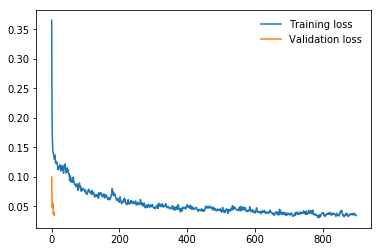

498
torch.Size([513, 21])
498
torch.Size([513, 21])


In [65]:
mask, mask_test = train_network(nr_epochs=900, train_set=train_set, test_set=test_set)

print(len(mask))
print(mask[0].shape)

print(len(mask_test))
print(mask_test[0].shape)

# apply generate mask from training, testing after training and validation 
split_audios_epoch("training-mask", mask)
split_audios_epoch("training-TEST-mask", mask_test)

# valid_mask = eval(network=network, test_set=test_set)
# split_audios_epoch("validation-mask", valid_mask)

Validation set loss: 0.03483397478874761


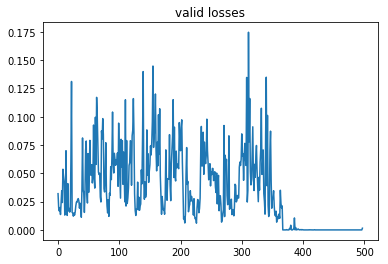

torch.Size([513, 21])


In [67]:
# apply generate mask from training, testing after training and validation 
# split_audios_epoch("training-mask", mask)
# split_audios_epoch("training-TEST-mask", mask_test)
torch.cuda.empty_cache()
network = torch.load('./model.pth')
valid_mask = eval(network=network, test_set=test_set)

print(valid_mask[0].shape)
split_audios_epoch("validation-mask", valid_mask)

input and target sent to CUDA
Train Epoch: 1 [0/997 (0%)]	Loss: 0.045482
Train Epoch: 1 [10/997 (1%)]	Loss: 0.040284
Train Epoch: 1 [20/997 (2%)]	Loss: 0.108915
Train Epoch: 1 [30/997 (3%)]	Loss: 0.386990
Train Epoch: 1 [40/997 (4%)]	Loss: 0.535919
Train Epoch: 1 [50/997 (5%)]	Loss: 0.502154
Train Epoch: 1 [60/997 (6%)]	Loss: 0.428798
Train Epoch: 1 [70/997 (7%)]	Loss: 0.342384
Train Epoch: 1 [80/997 (8%)]	Loss: 0.279553
Train Epoch: 1 [90/997 (9%)]	Loss: 0.338721
Train Epoch: 1 [100/997 (10%)]	Loss: 0.207496
Train Epoch: 1 [110/997 (11%)]	Loss: 0.104407
Train Epoch: 1 [120/997 (12%)]	Loss: 0.052740
Train Epoch: 1 [130/997 (13%)]	Loss: 0.093411
Train Epoch: 1 [140/997 (14%)]	Loss: 0.328593
Train Epoch: 1 [150/997 (15%)]	Loss: 0.057406
Train Epoch: 1 [160/997 (16%)]	Loss: 0.247350
Train Epoch: 1 [170/997 (17%)]	Loss: 0.368980
Train Epoch: 1 [180/997 (18%)]	Loss: 0.216839
Train Epoch: 1 [190/997 (19%)]	Loss: 0.076148
Train Epoch: 1 [200/997 (20%)]	Loss: 0.066559
Train Epoch: 1 [210/997 (

o tensor([0.1374, 0.1458, 0.1371,  ..., 0.1963, 0.1985, 0.1882], device='cuda:0')
t tensor([0.2914, 0.2912, 0.2906,  ..., 0.3812, 0.3812, 0.3811], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1425, 0.1464, 0.1369,  ..., 0.1971, 0.1989, 0.1881], device='cuda:0')
t tensor([0.8507, 0.8507, 0.8507,  ..., 0.1821, 0.1822, 0.1823], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1394, 0.1460, 0.1372,  ..., 0.1968, 0.1987, 0.1891], device='cuda:0')
t tensor([0.9335, 0.9334, 0.9333,  ..., 0.0684, 0.0683, 0.0683], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1397, 0.1463, 0.1370,  ..., 0.1966, 0.1964, 0.1866], device='cuda:0')
t tensor([0.9413, 0.9413, 0.9414,  ..., 0.7688, 0.7688, 0.7688], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1366, 0.1458, 0.1374,  ..., 0.1962, 0.1964, 0.1873], device='cuda:0')
t tensor([0.6306, 

correct 0
--------------------------
o tensor([0.1373, 0.1460, 0.1374,  ..., 0.1964, 0.1980, 0.1884], device='cuda:0')
t tensor([0.6337, 0.6337, 0.6334,  ..., 0.2633, 0.2631, 0.2630], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1384, 0.1458, 0.1376,  ..., 0.1963, 0.1968, 0.1874], device='cuda:0')
t tensor([0.7495, 0.7496, 0.7497,  ..., 0.1181, 0.1182, 0.1182], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1363, 0.1465, 0.1370,  ..., 0.1962, 0.1959, 0.1865], device='cuda:0')
t tensor([0.8907, 0.8907, 0.8908,  ..., 0.0620, 0.0618, 0.0618], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1384, 0.1460, 0.1374,  ..., 0.1966, 0.1982, 0.1886], device='cuda:0')
t tensor([0.2725, 0.2721, 0.2709,  ..., 0.5479, 0.5479, 0.5479], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1422, 0.1466, 0.1367,  ..., 0.1967, 0.1966, 0.1862]

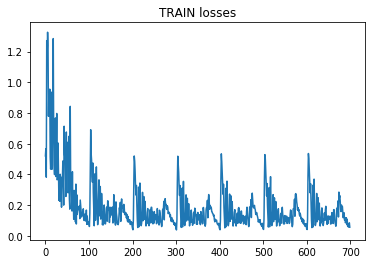

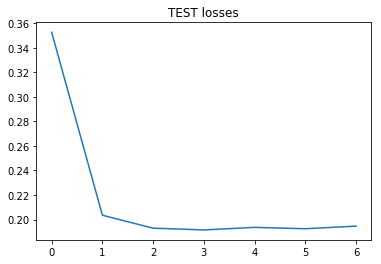

input and target sent to CUDA
Train Epoch: 2 [0/997 (0%)]	Loss: 0.046808
Train Epoch: 2 [10/997 (1%)]	Loss: 0.041776
Train Epoch: 2 [20/997 (2%)]	Loss: 0.111372
Train Epoch: 2 [30/997 (3%)]	Loss: 0.398673
Train Epoch: 2 [40/997 (4%)]	Loss: 0.554127
Train Epoch: 2 [50/997 (5%)]	Loss: 0.486398
Train Epoch: 2 [60/997 (6%)]	Loss: 0.422419
Train Epoch: 2 [70/997 (7%)]	Loss: 0.338737
Train Epoch: 2 [80/997 (8%)]	Loss: 0.268588
Train Epoch: 2 [90/997 (9%)]	Loss: 0.358855
Train Epoch: 2 [100/997 (10%)]	Loss: 0.185204
Train Epoch: 2 [110/997 (11%)]	Loss: 0.099064
Train Epoch: 2 [120/997 (12%)]	Loss: 0.053698
Train Epoch: 2 [130/997 (13%)]	Loss: 0.093940
Train Epoch: 2 [140/997 (14%)]	Loss: 0.311855
Train Epoch: 2 [150/997 (15%)]	Loss: 0.057570
Train Epoch: 2 [160/997 (16%)]	Loss: 0.249835
Train Epoch: 2 [170/997 (17%)]	Loss: 0.352981
Train Epoch: 2 [180/997 (18%)]	Loss: 0.202833
Train Epoch: 2 [190/997 (19%)]	Loss: 0.077381
Train Epoch: 2 [200/997 (20%)]	Loss: 0.064421
Train Epoch: 2 [210/997 (

o tensor([0.1739, 0.1600, 0.1272,  ..., 0.1896, 0.2651, 0.2016], device='cuda:0')
t tensor([0.2856, 0.2856, 0.2854,  ..., 0.8735, 0.8735, 0.8735], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1724, 0.1603, 0.1262,  ..., 0.1891, 0.2643, 0.1998], device='cuda:0')
t tensor([0.1827, 0.1823, 0.1809,  ..., 0.9637, 0.9637, 0.9637], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1786, 0.1604, 0.1267,  ..., 0.1889, 0.2592, 0.1971], device='cuda:0')
t tensor([0.3747, 0.3743, 0.3730,  ..., 0.6949, 0.6949, 0.6949], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1744, 0.1601, 0.1264,  ..., 0.1891, 0.2660, 0.1992], device='cuda:0')
t tensor([0.2302, 0.2302, 0.2301,  ..., 0.6374, 0.6371, 0.6370], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1678, 0.1607, 0.1254,  ..., 0.1892, 0.2613, 0.1982], device='cuda:0')
t tensor([0.2914, 

o tensor([0.1796, 0.1602, 0.1274,  ..., 0.1896, 0.2608, 0.2021], device='cuda:0')
t tensor([0.6500, 0.6501, 0.6502,  ..., 0.7238, 0.7240, 0.7240], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1520, 0.1557, 0.1898,  ..., 0.2928, 0.2899, 0.3208], device='cuda:0')
t tensor([0.2068, 0.2069, 0.2069,  ..., 0.8895, 0.8895, 0.8894], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1718, 0.1602, 0.1271,  ..., 0.1903, 0.2561, 0.2024], device='cuda:0')
t tensor([0.0011, 0.0011, 0.0011,  ..., 0.9777, 0.9777, 0.9777], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1667, 0.1605, 0.1253,  ..., 0.1886, 0.2406, 0.1936], device='cuda:0')
t tensor([0.0587, 0.0587, 0.0587,  ..., 0.9461, 0.9463, 0.9464], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1733, 0.1610, 0.1246,  ..., 0.1882, 0.2418, 0.1913], device='cuda:0')
t tensor([0.1505, 

correct 0
--------------------------
o tensor([0.1811, 0.1573, 0.1628,  ..., 0.2196, 0.2673, 0.2513], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1695, 0.1614, 0.1602,  ..., 0.2263, 0.2245, 0.2190], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1737, 0.1589, 0.1499,  ..., 0.2146, 0.2590, 0.2364], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1617, 0.1601, 0.1791,  ..., 0.2724, 0.2397, 0.2545], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1594, 0.1585, 0.1422,  ..., 0.2071, 0.2458, 0.2253], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-------------------

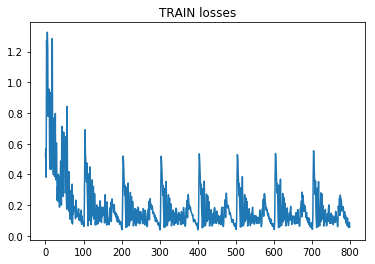

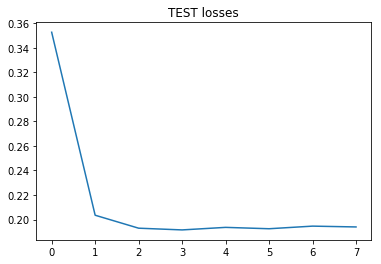

input and target sent to CUDA
Train Epoch: 3 [0/997 (0%)]	Loss: 0.047355
Train Epoch: 3 [10/997 (1%)]	Loss: 0.042477
Train Epoch: 3 [20/997 (2%)]	Loss: 0.111148
Train Epoch: 3 [30/997 (3%)]	Loss: 0.411402
Train Epoch: 3 [40/997 (4%)]	Loss: 0.524188
Train Epoch: 3 [50/997 (5%)]	Loss: 0.476661
Train Epoch: 3 [60/997 (6%)]	Loss: 0.484674
Train Epoch: 3 [70/997 (7%)]	Loss: 0.326203
Train Epoch: 3 [80/997 (8%)]	Loss: 0.288811
Train Epoch: 3 [90/997 (9%)]	Loss: 0.310285
Train Epoch: 3 [100/997 (10%)]	Loss: 0.226459
Train Epoch: 3 [110/997 (11%)]	Loss: 0.097029
Train Epoch: 3 [120/997 (12%)]	Loss: 0.051276
Train Epoch: 3 [130/997 (13%)]	Loss: 0.091516
Train Epoch: 3 [140/997 (14%)]	Loss: 0.384715
Train Epoch: 3 [150/997 (15%)]	Loss: 0.056904
Train Epoch: 3 [160/997 (16%)]	Loss: 0.221418
Train Epoch: 3 [170/997 (17%)]	Loss: 0.375565
Train Epoch: 3 [180/997 (18%)]	Loss: 0.229129
Train Epoch: 3 [190/997 (19%)]	Loss: 0.078448
Train Epoch: 3 [200/997 (20%)]	Loss: 0.064010
Train Epoch: 3 [210/997 (

o tensor([0.1603, 0.1481, 0.1420,  ..., 0.1913, 0.2060, 0.1986], device='cuda:0')
t tensor([0.3747, 0.3743, 0.3730,  ..., 0.6949, 0.6949, 0.6949], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1596, 0.1474, 0.1421,  ..., 0.1911, 0.2058, 0.1984], device='cuda:0')
t tensor([0.2302, 0.2302, 0.2301,  ..., 0.6374, 0.6371, 0.6370], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1518, 0.1443, 0.1415,  ..., 0.1886, 0.2027, 0.1936], device='cuda:0')
t tensor([0.2914, 0.2912, 0.2906,  ..., 0.3812, 0.3812, 0.3811], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1608, 0.1477, 0.1422,  ..., 0.1915, 0.2057, 0.1990], device='cuda:0')
t tensor([0.8507, 0.8507, 0.8507,  ..., 0.1821, 0.1822, 0.1823], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1590, 0.1488, 0.1420,  ..., 0.1927, 0.2095, 0.2005], device='cuda:0')
t tensor([0.9335, 

t tensor([0.6500, 0.6501, 0.6502,  ..., 0.7238, 0.7240, 0.7240], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1803, 0.1877, 0.1708,  ..., 0.3037, 0.2865, 0.3132], device='cuda:0')
t tensor([0.2068, 0.2069, 0.2069,  ..., 0.8895, 0.8895, 0.8894], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1578, 0.1449, 0.1425,  ..., 0.1885, 0.2022, 0.1939], device='cuda:0')
t tensor([0.0011, 0.0011, 0.0011,  ..., 0.9777, 0.9777, 0.9777], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1413, 0.1443, 0.1414,  ..., 0.1870, 0.2000, 0.1905], device='cuda:0')
t tensor([0.0587, 0.0587, 0.0587,  ..., 0.9461, 0.9463, 0.9464], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1493, 0.1428, 0.1416,  ..., 0.1871, 0.2000, 0.1898], device='cuda:0')
t tensor([0.1505, 0.1516, 0.1547,  ..., 0.3629, 0.3629, 0.3630], device='cuda:0')
------------------

t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1766, 0.1481, 0.1661,  ..., 0.2287, 0.2263, 0.2358], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1730, 0.1631, 0.1529,  ..., 0.2352, 0.2447, 0.2368], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1756, 0.1563, 0.1737,  ..., 0.2665, 0.2435, 0.2637], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1506, 0.1601, 0.1469,  ..., 0.2037, 0.2226, 0.2089], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
[0.3525697973107502, 0.20350569114462663, 0.19294637319264762, tensor(0.1915, device='cuda:0'), tensor(0.1936, dev

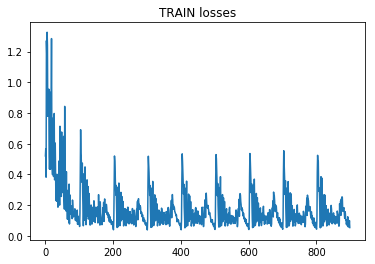

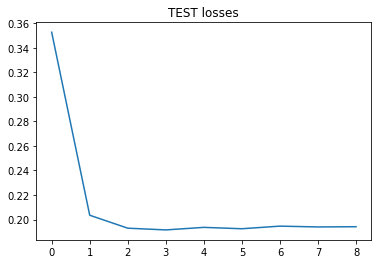

DONE


In [225]:
# CE E IN JOS DE AICI ERA TESTARE MAI VECHE, O PASTREZ JUST IN CASE

for epoch in range(1, n_epochs + 1):
    mask = train(epoch)
    test()  
#     split_audios_epoch(epoch, mask)
    
    plt.plot(train_losses)
    plt.title('TRAIN losses')
    plt.show()
    
    plt.plot(test_losses)
    plt.title('TEST losses')
    plt.show()

print("DONE")
# print(len(mask))

In [222]:
def train(epoch):
    mask = []
    network.train()
    
    # input is an AF, target is the mask for the PF of the current AF
    for index, (input, target) in enumerate(train_set.items()):
        
        assert(input.shape == (4, 1, 513, 11))
        assert(target.shape == (513, 11))

        target_view = target.view(-1, target.shape[0] * target.shape[1])
        
        # if cuda is available, send (input, target) to gpu
        if torch.cuda.is_available():
            input, target_view = input.cuda(), target_view.cuda()
            if index == 0:
                print("input and target sent to CUDA")

        optimizer.zero_grad()
        
        # 1. forward propagation
        output = network(input)
        
        # 2. loss calculation
        loss = loss_function(output[len(output)-1], target_view[0])       
        
        # 3. backward propagation
        loss.backward() 
        
        # 4. weight optimization
        optimizer.step()
            
        
        current_mask = output[len(output)-1].view(target.shape[0], target.shape[1])
        mask.append(output[len(output)-1])

        if index % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, index, len(train_set),
            100. * index / len(train_set), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (index) + ((epoch-1)*len(train_set.items())))
#             torch.save(network.state_dict(), './results/model.pth')
#             torch.save(optimizer.state_dict(), './results/optimizer.pth')

    return mask

In [223]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for index, (input, target) in enumerate(test_set.items()):
            
            # if cuda is available, send (input, target) to gpu
            target_view = target.view(-1, target.shape[0] * target.shape[1])
            if torch.cuda.is_available():
                input, target_view = input.cuda(), target_view.cuda()
                if index == 0:
                    print("input and target sent to CUDA")
            
            output = network(input)
            
            test_loss += loss_function(output[len(output)-1], target_view[0])
            
            correct += (int)(torch.eq(output[len(output)-1], target_view[0]).sum())
            
#             print("test loss",test_loss)
            if index % 100 == 0:
                print("correct",correct)
                print("--------------------------")
                print("o",output[len(output)-1])
                print("t",target_view[0])
                print("-----------------------")

#             break
            
    test_loss /= len(test_set)
    test_losses.append(test_loss)
    print(test_losses)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_set),
    100. * correct / len(test_set)))